In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
from datetime import timedelta
import os
import sys
sys.path.append('../../src')
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from aosol.armazenamento import bateria
from IPython.display import HTML, display, display_html
import warnings
from tabulate import tabulate

# Procura UPAC

Qual a UPAC que poderá permitir um menor custo de energia?

Estudo de diferentes tamanhos de UPAC e bateria e cálculo de indice de auto suficiência (IAS) e custo de energia.
O tamanho do sistema é definido pelos seguintes parâmetros:

$r_{pv} = \frac{Producao_{PV}}{Consumo} \left[ \frac{kWh}{kWh} \right]$

$r_{bat} = \frac{CAP_{bat}}{Consumo} \left[ \frac{kWh}{MWh} \right]$

Para perfil de consumo é usado o perfil de carga médio da e-redes ajustado para um valor de consumo anual enquanto o perfil de produção é obtido do PVGIS.

Inspirado no artigo:

S. Quoilin, K. Kavvadias, A. Mercier, I. Pappone, A. Zucker, 
Quantifying self-consumption linked to solar home battery systems: statistical analysis and economic assessment, 
Applied Energy, 2016

In [51]:
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 8400 # kWh, exemplo consumo médio 700 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 40.280  # Covilha
lon = -7.504
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %

# =====================
# Sistema
# =====================
eficiencia_inversor = 0.96
eficiencia_bateria = 0.92
soc_min = 0.1 
soc_max = 0.9

# =====================
# Custos
# =====================
params_financeiros = {
    "tempo_vida": 20,
    "tempo_vida_bat": 10,
    "pv_por_kW": 1000,
    "bat_fixo": 300,
    "bat_euro_por_kWh": 450,
    "perc_custo_manutencao": 0.5, # em %
    "taxa_actualizacao": 5, # em %
    "simples_kwh": 0.1492,    # simples (gold energy)
    "vazio_kwh": 0.1001,      # bihorario (galp)
    "fora_vazio_kwh": 0.1751, # bihorario (galp)
    "preco_venda_rede": 0.04  # 4cent/kWh
}

# precos energia
preco_venda_rede= 0.04 # 4cent/kWh



## Consumo

In [52]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 8400.0 kWh


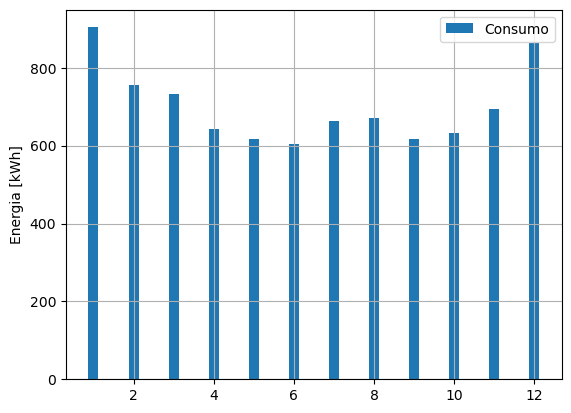

In [53]:
consumo_mensal = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(consumo_mensal.index.month, consumo_mensal, width=width, label='Consumo')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

## Produção

Obter disponibilidae PV com sistema de 1kWp para a localização escolhida. Sistema virado a sul com inclinação 30º

Text(0.5, 1.0, 'Disponibilidade PV')

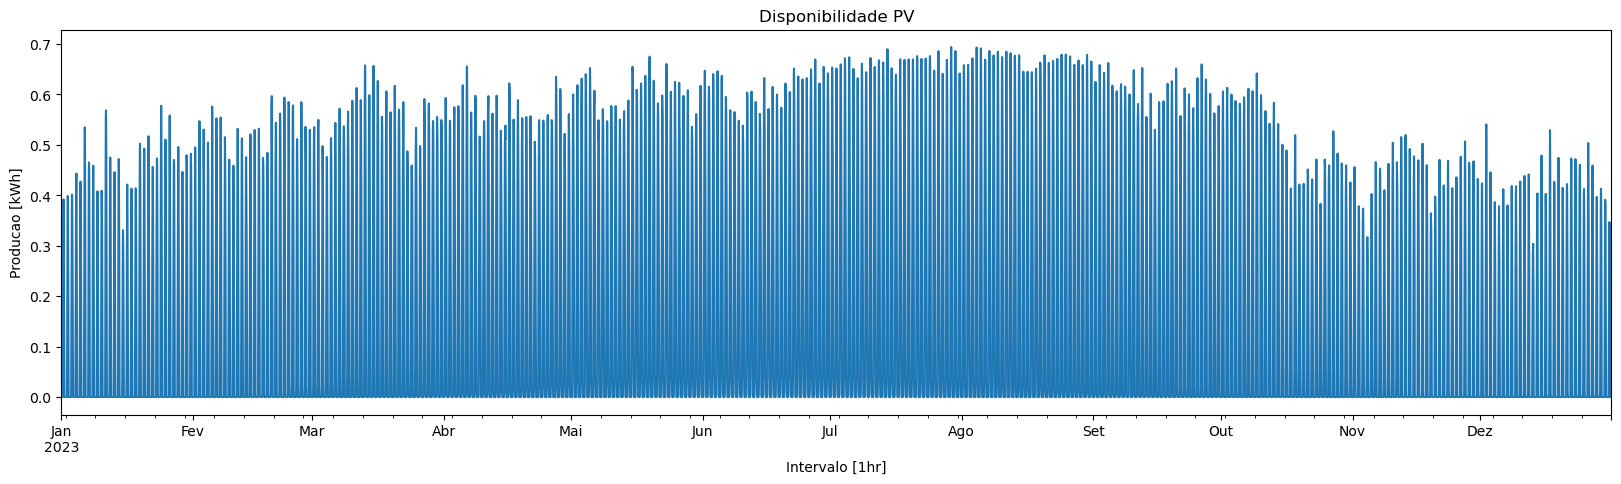

In [54]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=1, loss=perdas)
producao = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

p,ax = plt.subplots(1,1, figsize=(20,5))
producao["autoproducao"].plot(ax=ax)
plt.ylabel('Producao [kWh]')
plt.xlabel('Intervalo [1hr]')
plt.title('Disponibilidade PV')

## Estudo de UPAC sem bateria

Estudo de sistema com $0 \leq r_{PV} \leq 3$. Desde sem instalação de PV até sistema que produz 3x o consumo anual.

In [55]:
def estudo_parametrico_sem_bateria(tarifario, params_financeiros):
    r_pv = np.linspace(0, 3, 30)
    warnings.filterwarnings('ignore') 
    neps = producao["autoproducao"].sum()

    results = pd.DataFrame()
    custo_medio_sem_pv = 0

    for i in range(len(r_pv)):
        tot_producao = r_pv[i] * consumo_anual
        pot_instalada = tot_producao / neps

        energia = consumo.copy()
        energia["autoproducao"] = producao["autoproducao"] * pot_instalada

        energia = ae.analisa_upac_sem_armazenamento(energia)
        indicadores = ae.calcula_indicadores_autoconsumo(energia, pot_instalada, eficiencia_inversor)
        indicadores = indicadores.to_frame()

        indicadores["r_pv"] = r_pv[i]
        params_financeiros["preco_venda_rede"] = 0.0
        indicadores["lcoe s/ venda"], _, custo_medio_rede = af.custo_energia_prosumidor(energia, pot_instalada, 0, tarifario, params_financeiros)
        if r_pv[i] == 0.0:
            custo_medio_sem_pv = custo_medio_rede

        params_financeiros["preco_venda_rede"] = preco_venda_rede
        indicadores["lcoe c/ venda"], _, _ = af.custo_energia_prosumidor(energia, pot_instalada, 0, tarifario, params_financeiros)
        results = pd.concat([results, indicadores])

    results = results.set_index("r_pv")
    return results, custo_medio_sem_pv

def plot_estudo_sem_bateria(results, ax, titulo):
    idx_min_s_venda = results["lcoe s/ venda"].idxmin()
    min_lcoe_s_venda = results.loc[idx_min_s_venda]['lcoe s/ venda']
    min_ias_s_venda = results.loc[idx_min_s_venda]['IAS: Contributo PV [%]']
    min_pv_s_venda = results.loc[idx_min_s_venda]['Potencia instalada [kW]']

    idx_min_c_venda = results["lcoe c/ venda"].idxmin()
    min_lcoe_c_venda = results.loc[idx_min_c_venda]['lcoe c/ venda']
    min_ias_c_venda = results.loc[idx_min_c_venda]['IAS: Contributo PV [%]']
    min_pv_c_venda = results.loc[idx_min_c_venda]['Potencia instalada [kW]']


    results.plot(y=["lcoe s/ venda", "lcoe c/ venda"], style='--', legend=False, ax=ax)
    ax.set_xlabel("Racio PV")
    ax.set_ylabel("LCOE [€/kWh]")
    ax.grid()    
    ax.set_title(titulo)

    ax1 = ax.twinx()
    results.plot(y=["IAS: Contributo PV [%]", "IAC: Indice Auto consumo [%]"], ax=ax1, legend=False)
    ax1.set_ylabel('Indicadores [%]')

    print(f'Sem venda rede: {round(min_pv_s_venda,1)} kWp com custo energia = {round(min_lcoe_s_venda,2)} €/kWh para IAS = {round(min_ias_s_venda,1)} %')
    print(f'Com venda rede: {round(min_pv_c_venda,1)} kWp com custo energia = {round(min_lcoe_c_venda,2)} €/kWh para IAS = {round(min_ias_c_venda,1)} %')
    ax.axvline(x=idx_min_s_venda, color='grey', linestyle='--')
    ax.scatter([idx_min_s_venda],[min_lcoe_s_venda])
    ax.annotate(
        f'({round(idx_min_s_venda, 2)}, {round(min_lcoe_s_venda,2)})',
        xy=(idx_min_s_venda, min_lcoe_s_venda))
    ax1.scatter([idx_min_s_venda],[min_ias_s_venda])
    ax1.annotate(
        f'({round(idx_min_s_venda,2)}, {round(min_ias_s_venda,1)})',
        xy=(idx_min_s_venda, min_ias_s_venda))


    ax.axvline(x=idx_min_c_venda, color='grey', linestyle='--')
    ax.scatter([idx_min_c_venda],[min_lcoe_c_venda])
    ax.annotate(
        f'({round(idx_min_c_venda, 2)}, {round(min_lcoe_c_venda,2)})',
        xy=(idx_min_c_venda, min_lcoe_c_venda))
    ax1.scatter([idx_min_c_venda], [min_ias_c_venda])
    ax1.annotate(
        f'({round(idx_min_c_venda,2)}, {round(min_ias_c_venda,1)})',
        xy=(idx_min_c_venda, min_ias_c_venda))

    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax1.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

Tarifario simples:
Custo energia sem PV = 0.1492 €/kWh
Sem venda rede: 2.4 kWp com custo energia = 0.12 €/kWh para IAS = 34.9 %
Com venda rede: 3.0 kWp com custo energia = 0.12 €/kWh para IAS = 37.7 %
Tarifario bihorario:
Custo energia sem PV = 0.1501 €/kWh
Sem venda rede: 2.4 kWp com custo energia = 0.11 €/kWh para IAS = 34.9 %
Com venda rede: 3.6 kWp com custo energia = 0.11 €/kWh para IAS = 39.4 %


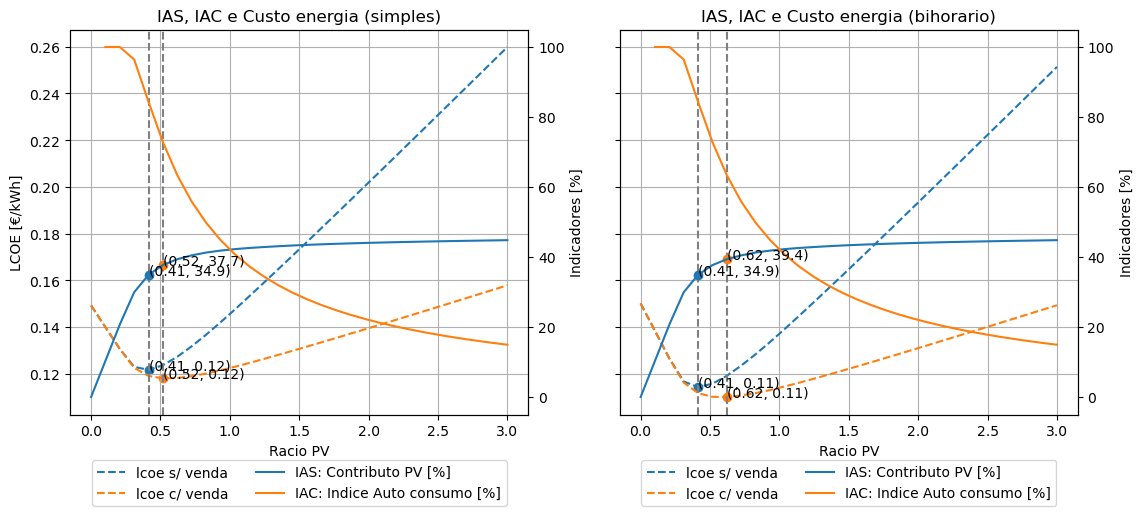

In [56]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

results_simples, c = estudo_parametrico_sem_bateria(ape.Tarifario.Simples, params_financeiros)
print("Tarifario simples:")
print(f"Custo energia sem PV = {c:.4f} €/kWh")
plot_estudo_sem_bateria(results_simples, ax[0], "IAS, IAC e Custo energia (simples)")

results_bihorario, cb = estudo_parametrico_sem_bateria(ape.Tarifario.Bihorario, params_financeiros)
print("Tarifario bihorario:")
print(f"Custo energia sem PV = {cb:.4f} €/kWh")
plot_estudo_sem_bateria(results_bihorario, ax[1], "IAS, IAC e Custo energia (bihorario)")


## Estudo sistema com bateria

Sistema com $0.5 \leq r_{PV} \leq 2.5$ e $0 \leq r_{bat} \leq 2$

In [57]:
def estudo_parametrico_com_bateria(tarifario, params_financeiros):
    ratios_pv = np.linspace(0.5, 2.5, 20)
    ratios_bat = np.linspace(0, 2, 20)

    PV, BAT = np.meshgrid(ratios_pv, ratios_bat)
    LCOE = np.zeros(PV.shape)
    neps = producao["autoproducao"].sum()
    results_bat = pd.DataFrame()

    for i in range(len(ratios_pv)):
        for j in range(len(ratios_bat)):
            r_pv = ratios_pv[i]
            r_bat = ratios_bat[j]
            #print(f'r_pv = {r_pv} r_bat = {r_bat}')

            tot_producao = r_pv * consumo_anual
            pot_instalada = tot_producao / neps

            cap_bat = r_bat * (consumo_anual/1000)
            bat = bateria.bateria(cap_bat, soc_min, soc_max, eficiencia_bateria)
            energia = consumo.copy()
            energia["autoproducao"] = producao["autoproducao"] * pot_instalada

            energia = ae.analisa_upac_com_armazenamento(energia, bat, eficiencia_inversor=eficiencia_inversor)
            indicadores = ae.calcula_indicadores_autoconsumo(energia, pot_instalada, eficiencia_inversor, bat)
            indicadores = indicadores.to_frame()

            params_financeiros["preco_venda_rede"] = 0.0
            #lcoe_s_venda, lcos_s_venda = af.custo_energia_prosumidor(pot_instalada, cap_bat, energia["consumo_rede"].sum(), energia["injeccao_rede"].sum(), energia["descarga_bateria"].sum(), consumo_anual, params_financeiros)
            lcoe_s_venda, lcos_s_venda, _ = af.custo_energia_prosumidor(energia, pot_instalada, cap_bat, tarifario, params_financeiros)
            params_financeiros["preco_venda_rede"] = preco_venda_rede
            #lcoe_c_venda, lcos_c_venda = af.custo_energia_prosumidor(energia, pot_instalada, cap_bat, energia["consumo_rede"].sum(), energia["injeccao_rede"].sum(), energia["descarga_bateria"].sum(), consumo_anual, params_financeiros)
            lcoe_c_venda, lcos_c_venda, _ = af.custo_energia_prosumidor(energia, pot_instalada, cap_bat, tarifario, params_financeiros)
            LCOE[i, j] = lcoe_c_venda
            indicadores["r_pv"] = r_pv
            indicadores["r_bat"] = r_bat
            indicadores["lcoe s/ venda"] = lcoe_s_venda
            indicadores["lcos s/ venda"] = lcos_s_venda
            indicadores["lcoe c/ venda"] = lcoe_c_venda
            indicadores["lcos c/ venda"] = lcos_c_venda
            results_bat = pd.concat([results_bat, indicadores])

    IAS = results_bat["IAS: Contributo PV [%]"].values.reshape(len(ratios_pv), len(ratios_bat))
    return results_bat, PV, BAT, LCOE, IAS

def plot_estudo_com_bateria(PV, BAT, LCOE, IAS, ax, titulo):
    import matplotlib
    import matplotlib.cm as cm

    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'

    levels = np.arange(0.10,0.30,0.01)
    levels_ias = np.arange(30, 100, 5)
    #fig3, ax = plt.subplots(1, 2, figsize=(14, 6))
    #fig3 = plt.figure(figsize=(8, 6))

    CS1 = ax.contour(PV, BAT, IAS, colors='black', linewidths=1., linestyles='--', levels=levels_ias)
    CS = ax.contour(PV, BAT, LCOE, colors='black', linewidths=1.,levels=levels)
    CS2 = ax.contourf(PV, BAT, LCOE, cmap=cm.Purples, alpha=0.5,levels=levels)
    ax.grid()
    ax.clabel(CS, inline=1, fontsize=10)
    ax.clabel(CS1, inline=1, fontsize=10)
    ax.set_title(titulo)
    ax.set_xlabel('PV [kWh/kWh]')
    ax.set_ylabel('BATERIA [kWh/MWh]')

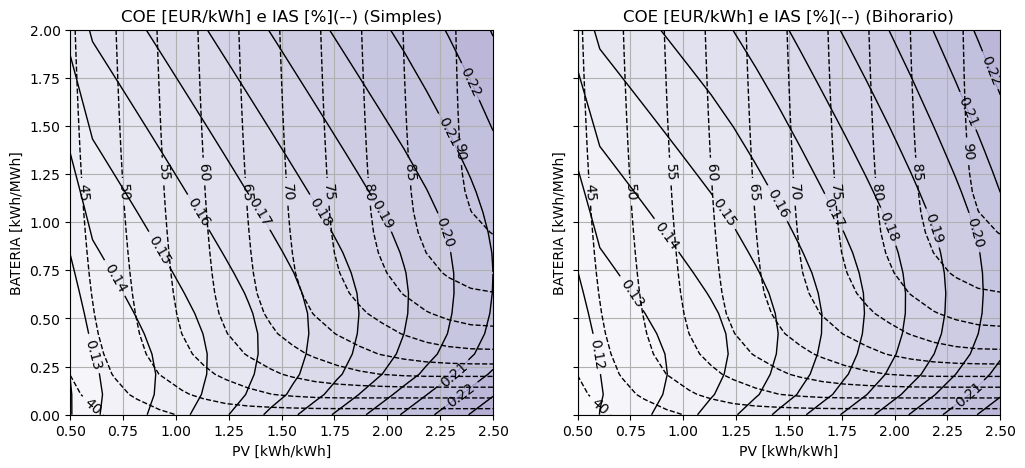

In [58]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

results_bat_simples, PV1, BAT1, LCOE1, IAS1 = estudo_parametrico_com_bateria(ape.Tarifario.Simples, params_financeiros)
plot_estudo_com_bateria(PV1, BAT1, LCOE1, IAS1, ax[0], 'COE [EUR/kWh] e IAS [%](--) (Simples)')

results_bat_bihorario, PV2, BAT2, LCOE2, IAS2 = estudo_parametrico_com_bateria(ape.Tarifario.Bihorario, params_financeiros)
plot_estudo_com_bateria(PV2, BAT2, LCOE2, IAS2, ax[1], 'COE [EUR/kWh] e IAS [%](--) (Bihorario)')

In [60]:
limite_lcoe = 0.13
limite_ias = 50

x = results_bat_bihorario.loc[(results_bat_bihorario["lcoe c/ venda"] < limite_lcoe) & (results_bat_bihorario["IAS: Contributo PV [%]"] > limite_ias)]
print(tabulate(x[["Potencia instalada [kW]", "Capacidade bateria [kWh]", "IAS: Contributo PV [%]", "lcoe c/ venda", "lcos c/ venda"]].sort_values("lcoe c/ venda"),
               headers=["Potencia instalada [kW]", "Capacidade bateria [kWh]", "IAS: Contributo PV [%]", "LCOE [€/kWh]", "LCOS [€/kWh]"],
               floatfmt=('.1f','.1f', '.1f', '.1f', '.4f', '.4f')))

               Potencia instalada [kW]    Capacidade bateria [kWh]    IAS: Contributo PV [%]    LCOE [€/kWh]    LCOS [€/kWh]
-----------  -------------------------  --------------------------  ------------------------  --------------  --------------
indicadores                        4.1                         3.5                      50.0          0.1299          0.2985
indicadores                        6.0                         2.7                      50.2          0.1299          0.2883
